In [35]:
import json
from datetime import datetime
import io
import json
import logging
import os
import random
import re
import textwrap
from collections import deque

import discord
import matplotlib.pyplot as plt
import numpy as np
from openai import OpenAI
import pandas as pd
import torch
from torch.utils.data import Dataset
import json
from openai import OpenAI

with open('../synthetic/synthetic_full.json', 'r') as json_file:
    results = json.load(json_file)

In [2]:
import os
token_path = '../../tokens.json'
if not os.path.isfile(token_path):
    raise Exception(f"{token_path} not found!")
with open(token_path) as f:
    # If you get an error here, it means your token is formatted incorrectly. Did you put it in quotes?
    tokens = json.load(f)
    discord_token = tokens['discord']
    openai_token = tokens['openai']

In [26]:
import shap
from transformers import BertTokenizer, BertForSequenceClassification
import torch

class ScamClassifier:
    def __init__(self):
        self.model = BertForSequenceClassification.from_pretrained('./scam_detection_model')
        self.tokenizer = BertTokenizer.from_pretrained('./scam_detection_tokenizer')
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.LABEL_MAPPING = {0: 'Not a Scam', 1: 'Scam'}
    def batch_predict_scammer(self, texts, batch_size=32):
        predictions = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]

            # Encode the batch of texts
            encodings = self.tokenizer.batch_encode_plus(
                batch_texts,
                max_length=512,
                truncation=True,
                padding='max_length',
                return_tensors='pt'
            )
            input_ids = encodings['input_ids'].to(self.device)
            attention_mask = encodings['attention_mask'].to(self.device)

            # Make prediction
            with torch.no_grad():
                outputs = self.model(input_ids, attention_mask=attention_mask)
                probabilities = torch.softmax(outputs.logits, dim=-1)
                predicted_classes = torch.argmax(probabilities, dim=1).cpu().numpy()

            predictions.extend(predicted_classes)

        return [self.LABEL_MAPPING[pred] for pred in predictions]

    
    def batch_predict_scammer_prob(self, texts, batch_size=32):
        predictions = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]

            # Encode the batch of texts
            encodings = self.tokenizer.batch_encode_plus(
                batch_texts,
                max_length=512,
                truncation=True,
                padding='max_length',
                return_tensors='pt'
            )
            input_ids = encodings['input_ids'].to(self.device)
            attention_mask = encodings['attention_mask'].to(self.device)

            # Make prediction
            with torch.no_grad():
                outputs = self.model(input_ids, attention_mask=attention_mask)
                probabilities = torch.softmax(outputs.logits, dim=-1)
                predicted_classes = torch.argmax(probabilities, dim=1).cpu().numpy()

            predictions.extend(probabilities.cpu().numpy())

        return predictions

    def predict_scammer(self, text):
        # Encode the text
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=512,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)

        # Make prediction
        with torch.no_grad():
            try:
                outputs = self.model(input_ids, attention_mask=attention_mask)
                probabilities = torch.softmax(outputs.logits, dim=-1)
                predicted_class = torch.argmax(probabilities, dim=1).cpu().item()
            except:
                print(outputs)
                print(input_ids)

        return self.LABEL_MAPPING[predicted_class]



In [27]:
sc = ScamClassifier()

In [28]:
def construct_classification_input(record):
    user_name = record['persona2_bio']['name']
    channel_topic = record['channel_topic']['channel']
    person_speak = [z['chat'] for z in  record['chat_history'] if z['name'] == user_name]

    chat_history = ' '.join(person_speak)
    ip_fraud_score = record['persona2_bio']['ip_info']['fraud_score']
    convo_history = f"""Channel: {channel_topic} \nFraud Score: {ip_fraud_score} \nMessage: {chat_history}"""
    return convo_history

In [24]:
classifier_inputs = [construct_classification_input(z) for z in results]

In [20]:
classifier_outputs = sc.batch_predict_scammer(classifier_inputs)

In [29]:
classifier_prob = sc.batch_predict_scammer_prob(classifier_inputs)

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc


def plot_confusion_matrix(y_true, y_pred, threshold=0.5, title='Confusion Matrix'):
    """
    Plots the confusion matrix given true labels and predicted scores/labels.
    
    Parameters:
    - y_true: List of true labels.
    - y_pred: List of predicted scores or labels.
    - threshold: Threshold for converting scores to labels (used if y_pred are scores).
    - title: Title for the plot.
    """
    # Convert predicted scores to labels based on the threshold
    y_pred_labels = [1 if score >= threshold else 0 for score in y_pred]
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center')
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("BERT Confusion Matrix")
    plt.xticks([0, 1], ['Not Scam', 'Scam'])
    plt.yticks([0, 1], ['Not Scam', 'Scam'])
    plt.show()

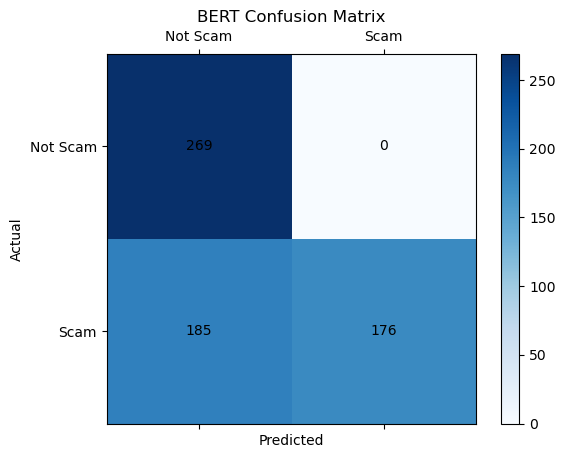

In [75]:
plot_confusion_matrix([z['is_scam'] for z in results], [z[1] for z in classifier_prob], threshold=0.9)

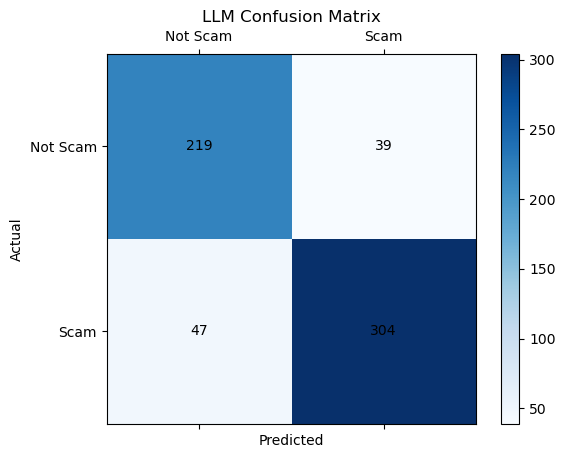

In [156]:
plot_confusion_matrix(true_labels_o, scores_o, threshold=40)

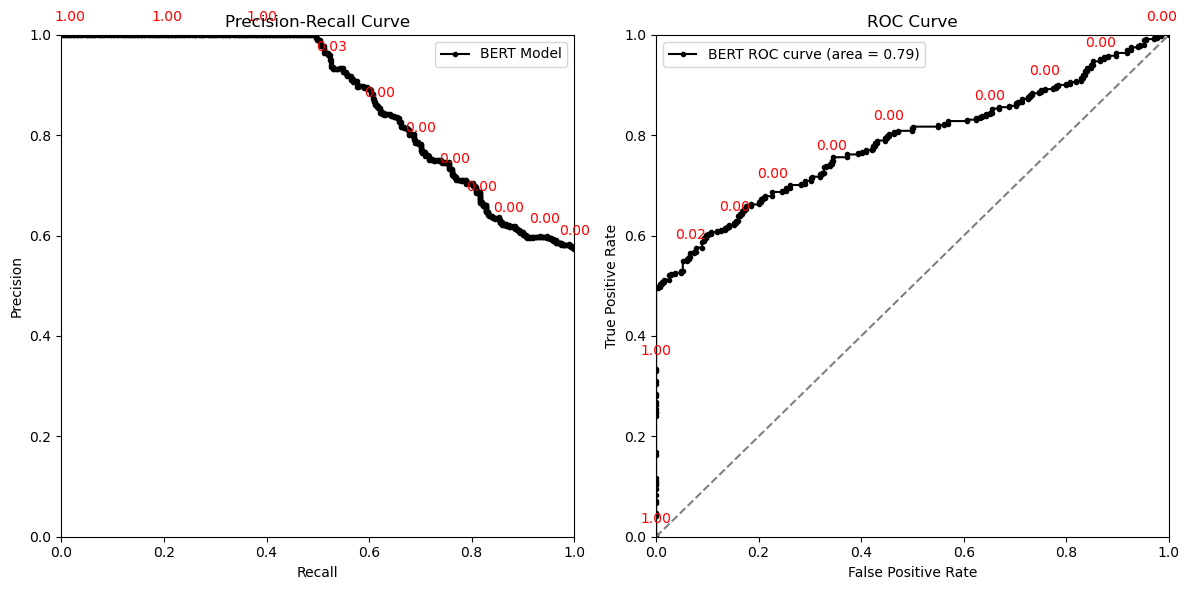

In [84]:

# Compute Precision-Recall and ROC curve values for GPT-4o
precision_o, recall_o, pr_thresholds_o = precision_recall_curve([z['is_scam'] for z in results], [z[1] for z in classifier_prob])
roc_fpr_o, roc_tpr_o, roc_thresholds_o = roc_curve([z['is_scam'] for z in results], [z[1] for z in classifier_prob])
roc_auc_o = auc(roc_fpr_o, roc_tpr_o)

# Plot Precision-Recall curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(recall_o, precision_o, marker='.', label='BERT Model', color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()

for i in range(len(pr_thresholds_o)):
    if i % (len(pr_thresholds_o) // 10) == 0:  # Annotate every 10th threshold
        plt.annotate(f'{pr_thresholds_o[i]:.2f}', (recall_o[i], precision_o[i]), textcoords="offset points", xytext=(0,10), ha='center', color='red')


# Plot ROC curves
plt.subplot(1, 2, 2)
plt.plot(roc_fpr_o, roc_tpr_o, marker='.', label=f'BERT ROC curve (area = {roc_auc_o:.2f})', color='black')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()

for i in range(len(roc_thresholds_o)):
    if i % (len(roc_thresholds_o) // 10) == 0:  # Annotate every 10th threshold
        plt.annotate(f'{min(1, roc_thresholds_o[i]):.2f}', (roc_fpr_o[i], roc_tpr_o[i]), textcoords="offset points", xytext=(0,10), ha='center', color='red')

plt.tight_layout()
plt.show()